<a href="https://colab.research.google.com/github/nermienkh/BMD212_Spring22/blob/main/104_Original_Frame_Light_Edges_%2BSailent_Object_Trimed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
from PIL import Image
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

In [2]:
!pip install pulse2percept
import pulse2percept as p2p
from pulse2percept.stimuli import ImageStimulus
from pulse2percept.implants import ArgusII , AlphaAMS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 4.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
imagePath="/content/drive/MyDrive/Images/blackbag.jpg"
loggerPath="/content/drive/MyDrive/Images/blackbag1.txt"

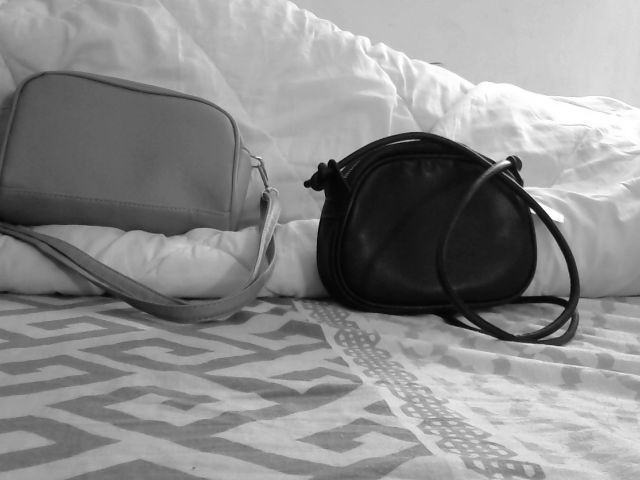

In [8]:
#read image from file
img =cv2.imread(imagePath)
img = cv2.cvtColor(np.asarray(img), cv2.COLOR_BGR2GRAY)
cv2_imshow(img)

In [9]:
#get rect dimension
with open(loggerPath, 'r') as fp:
    # lines to read
    line_numbers = [3]
    # To store lines
    lines = []
    for i, line in enumerate(fp):
        # read line 4 and 7
        if i in line_numbers:
            lines.append(line.strip())
        elif i > 7:
            # don't read after line 7 to save time
            break
#extract numbers
txt = lines[0]
import re
dimensions=re.findall(r'\d+', txt)
rect=list(map(lambda x:int(x),dimensions))

Text(0.5, 1.0, 'original')

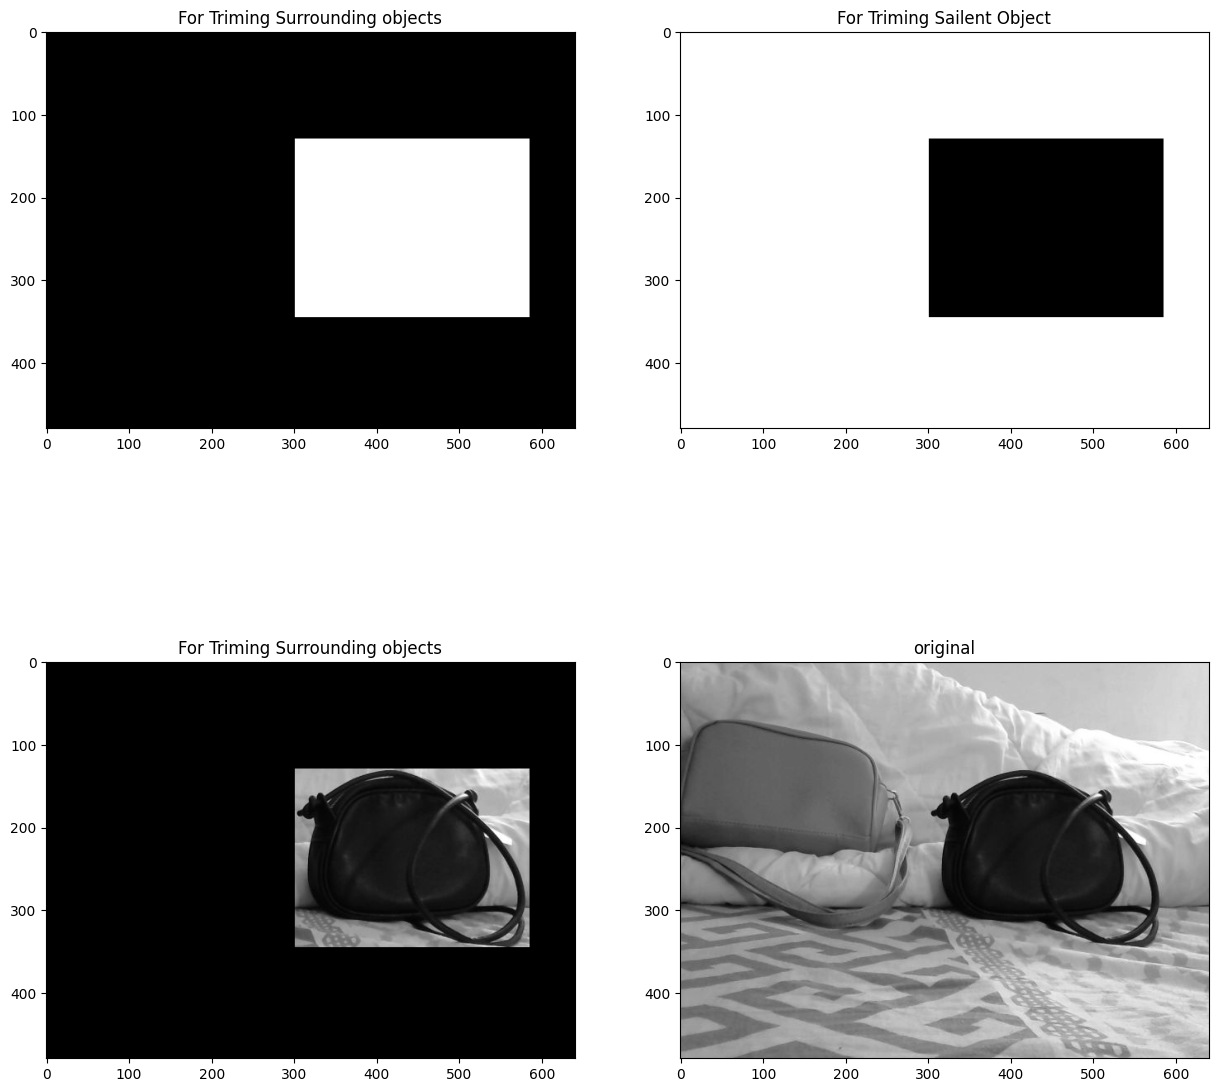

In [45]:
#create masked frames
#1- For Triming Surrounding objects
#2- For Triming Sailent Object
#prepare mask1
mask1 = np.zeros(img.shape[:2], dtype="uint8")
cv2.rectangle(mask1, (rect[0],rect[1]), (rect[2], rect[3]), 255, -1)

#prepare mask2
mask2 = np.zeros(img.shape[:2], dtype="uint8")
mask2.fill(255)
cv2.rectangle(mask2, (rect[0],rect[1]), (rect[2], rect[3]), 0, -1)

masked1 = cv2.bitwise_and(img, img, mask=mask1)
#asked2 = cv2.bitwise_and(img, img, mask=mask2)

f, axarr = plt.subplots(2,2, figsize=(15, 15))

axarr[0,0].imshow(mask1,cmap="gray")
axarr[0,0].set_title("For Triming Surrounding objects")
axarr[0,1].imshow(mask2,cmap="gray")
axarr[0,1].set_title("For Triming Sailent Object")

axarr[1,0].imshow(masked1,cmap="gray")
axarr[1,0].set_title("For Triming Surrounding objects")
axarr[1,1].imshow(img,cmap="gray")
axarr[1,1].set_title("original")

#Processing Part

In [28]:
def checkWhiteBackground(image,otsu_threshold):
      #few=numberOfCmnsORrowsToTest
      #firstFewcolumns=image[:,:few]
      #=image[:few,:]
      #firstFewcolumnsWhiteDotsCount=firstFewcolumns[firstFewcolumns==255]
      #firstFewRowsWhiteDotsCount=firstFewrows[firstFewrows==255]
      #return (firstFewcolumnsWhiteDotsCount.shape[0]>=(firstFewcolumns.shape[0]*firstFewcolumns.shape[1]*percentage) or firstFewRowsWhiteDotsCount.shape[0]>=(firstFewrows.shape[0]*firstFewrows.shape[1]*percentage))
      firstPixel=image[0][0]
      return (firstPixel>otsu_threshold)

Obtained threshold:  93.0


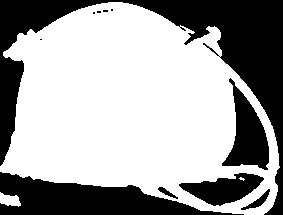

In [29]:
#Sailent Object Processing
trimed = masked1[rect[1]:rect[3],rect[0]:rect[2]]
otsu_threshold1, thresholdedImage = cv2.threshold(trimed, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print("Obtained threshold: ", otsu_threshold1)

#  invert if background white
if(checkWhiteBackground(thresholdedImage,otsu_threshold1)):
     thresholdedImage=cv2.bitwise_not(thresholdedImage)

thresholdedImage=cv2.medianBlur(thresholdedImage,3)
cv2_imshow( thresholdedImage)

Obtained threshold:  124.0


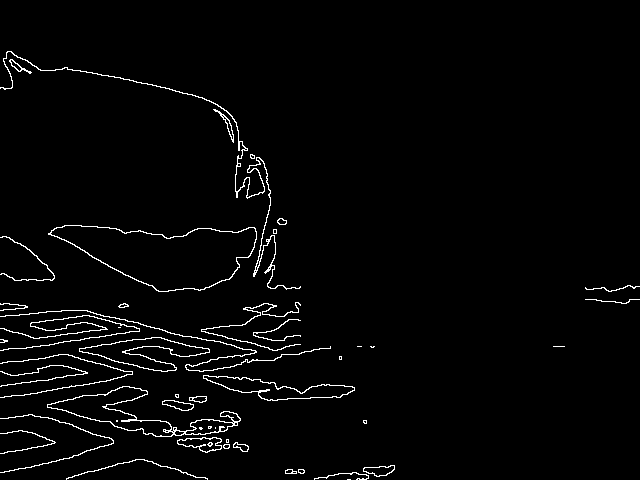

In [46]:
#Whole Image Processing
otsu_threshold2, thresholdedImage2 = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print("Obtained threshold: ", otsu_threshold2)
noiseCancelledImage2=cv2.medianBlur(thresholdedImage2,3)
kernel = np.ones((3,3))
erodedimage2 = cv2.erode(noiseCancelledImage2,kernel,iterations = 1)
imageWithEdges=noiseCancelledImage2-erodedimage2
masked2 = cv2.bitwise_and(imageWithEdges, imageWithEdges, mask=mask2)
cv2_imshow( masked2)

#Paste 2 Images

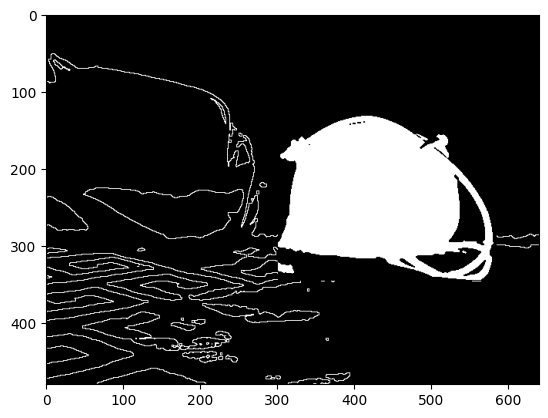

In [47]:
import matplotlib.pyplot as plt

#form array and scale the values from [0-1] to 255 lineary
smaall_part = Image.fromarray(thresholdedImage)
#smaall_part = Image.fromarray(trimed).convert("L")


#prepare balck frame
bigimage = masked2
bigimage=Image.fromarray(bigimage)

#paste object on the black frame
bigimage.paste(smaall_part,(rect[0], rect[1]))
plt.imshow(bigimage,cmap='gray')



#Percepts Model Setup





In [48]:
transforms = [p2p.utils.Curcio1990Map,
              p2p.utils.Watson2014Map,
              p2p.utils.Watson2014DisplaceMap]


#modelp2p = p2p.models.ScoreboardModel(xrange=(-7, 7), yrange=(-7, 7), xystep=0.1)
#modelp2p = p2p.models.ScoreboardSpatial(  xrange=(-360, 360), yrange=(-360, 360),xystep=1, retinotopy=transforms[0])
modelp2p = p2p.models.ScoreboardSpatial(xrange=(-12,12), yrange=(-12,12),xystep=0.1,retinotopy=transforms[0])

modelp2p.build()

ScoreboardSpatial(engine=None, grid_type='rectangular', 
                  n_gray=None, n_jobs=1, n_threads=2, 
                  noise=None, retinotopy=ABCMeta, rho=100, 
                  scheduler='threading', thresh_percept=0, 
                  verbose=True, xrange=(-12, 12), 
                  xystep=0.1, yrange=(-12, 12))

**AlphaAMS**

In [49]:

implant = AlphaAMS()

#generate my own implant
MyImplant = {};
gsize = (6, 10)
spacing = 0 #u microns
radius =  30 #u
egrid = p2p.implants.ElectrodeGrid(gsize, spacing,etype=p2p.implants.DiskElectrode,r=radius)
MyImplant = p2p.implants.ProsthesisSystem(egrid)


cv2.imwrite('object.png', np.array(bigimage))
#eroded.save("object.png")

#pulse2percept part

stim = ImageStimulus("object.png") #range (0-1)
#stim_edge = stim.filter('canny')
implant.stim= stim.resize(implant.shape)

#Then the implant can be passed to the model’s predict_percept method:
percept_gray = modelp2p.predict_percept(implant)



ArgusII

In [50]:

implant2 = ArgusII()


cv2.imwrite('object.png', np.array(bigimage))
#eroded.save("object.png")

#pulse2percept part

stim = ImageStimulus("object.png") #range (0-1)
#stim_edge = stim.filter('canny')
implant2.stim= stim.resize(implant2.shape)

#Then the implant can be passed to the model’s predict_percept method:
percept_gray2 = modelp2p.predict_percept(implant2)


Designed Implant 32*32

In [51]:

#generate my own implant
MyImplant = {};
gsize = (32, 32)
spacing = 70 #u microns
radius =  30 #u
egrid = p2p.implants.ElectrodeGrid(gsize, spacing,etype=p2p.implants.DiskElectrode,r=radius)
MyImplant = p2p.implants.ProsthesisSystem(egrid)


cv2.imwrite('object.png', np.array(bigimage))
#eroded.save("object.png")

#pulse2percept part

stim = ImageStimulus("object.png") #range (0-1)
#stim_edge = stim.filter('canny')
MyImplant.stim= stim.resize(MyImplant.earray.shape)

#Then the implant can be passed to the model’s predict_percept method:
percept_gray3 = modelp2p.predict_percept(MyImplant)

#resize frame to overlay

Text(0.5, 1.0, 'Designed Implant')

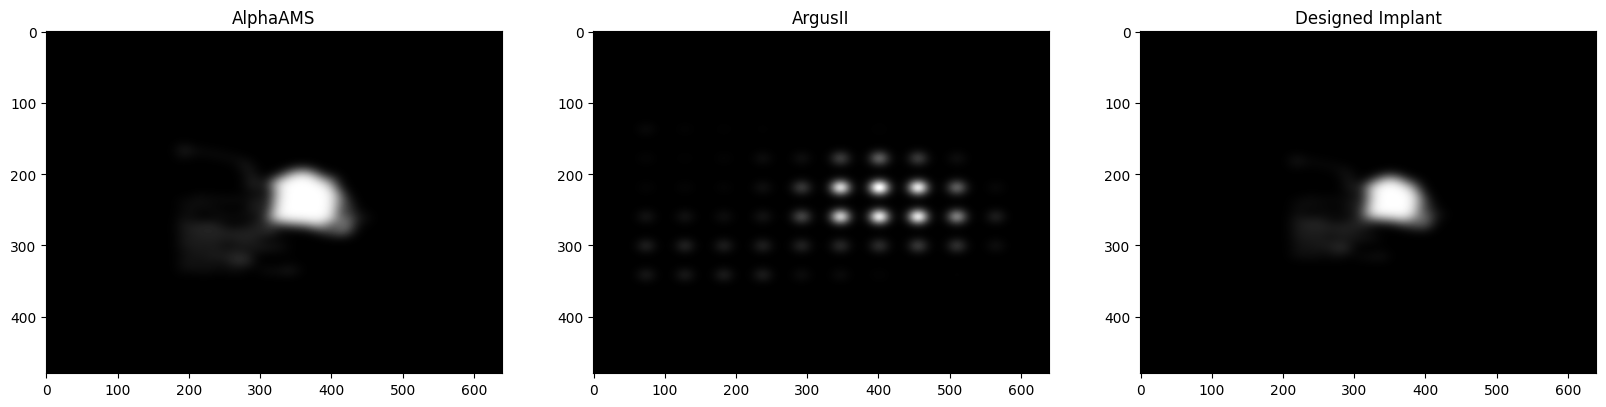

In [52]:
res1 = cv2.resize(percept_gray.data, dsize=(img.shape[1], img.shape[0]))
res2 = cv2.resize(percept_gray2.data, dsize=(img.shape[1], img.shape[0]))
res3 = cv2.resize(percept_gray3.data, dsize=(img.shape[1], img.shape[0]))


f, axarr = plt.subplots(1,3, figsize=(20, 20))

axarr[0].imshow(res1,cmap="gray")
axarr[0].set_title("AlphaAMS")
axarr[1].imshow(res2,cmap="gray")
axarr[1].set_title("ArgusII")

axarr[2].imshow(res3,cmap="gray")
axarr[2].set_title("Designed Implant")